In [1]:
!git clone https://github.com/amirhosein-mesbah/AMAlearn.git

fatal: destination path 'AMAlearn' already exists and is not an empty directory.


In [2]:
!ls

AMAlearn  drive  sample_data


In [3]:
%cd '/content/AMAlearn/'

/content/AMAlearn


In [4]:
!pwd

/content/AMAlearn


In [5]:
!pip install -e .

Obtaining file:///content/AMAlearn
  Attempting uninstall: amalearn
    Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.agent import RandomBanditAgent
from amalearn.reward import GaussianReward
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
!ls

amalearn  amalearn.egg-info  example  README.md  setup.py


In [41]:
PATH =  '/content/drive/MyDrive/Colab Notebooks/RL'
!cd  '/content/drive/MyDrive/Colab Notebooks/RL'

In [42]:
df = pd.read_csv(PATH +'/Q3.csv')
score_cost = df.columns
value_list = ['value_adidas_1','value_adidas_2','value_adidas_3','value_nike_1','value_nike_2','value_nike_3']
for i in range(len(value_list)):
  df[value_list[i]] = (2*df.loc[:,score_cost[i*2]])-df.loc[:,score_cost[i*2+1]] #i*2 = score ,#i*2+1 = cost

df_value = df.loc[:,value_list[0]:value_list[-1]]
df_value

,value_adidas_1,value_adidas_2,value_adidas_3,value_nike_1,value_nike_2,value_nike_3
0,16.497568,139.704216,73.458285,34.381618,-14.948887,98.860954
1,16.804450,138.210231,72.186072,32.919276,-14.159456,96.905975
2,14.236576,139.242001,76.199589,34.967789,-14.046893,94.777765
3,17.119705,138.317483,71.287096,34.012164,-13.960918,94.730192
4,18.689987,137.518487,69.842428,30.775041,-12.542346,94.715597
...,...,...,...,...,...,...
493,14.532414,139.937666,74.889853,33.603625,-14.616968,93.582424
494,15.679924,140.673617,75.553007,35.559644,-13.796267,94.302991
495,15.485966,138.556350,64.508815,37.208891,-14.280706,98.114178
496,14.371186,138.679608,70.105401,35.182948,-15.521007,95.440373


In [11]:
df_value.mean(axis = 0 )

value_adidas_1     15.652308
value_adidas_2    138.971658
value_adidas_3     72.871446
value_nike_1       34.201771
value_nike_2      -14.123851
value_nike_3       96.969251
dtype: float64

In [16]:
class Reward_value(RewardBase):
    def __init__(self,df):
        super(Reward_value, self ).__init__()

        self.value = df[0]

    def get_reward(self):
        rn = np.random.randint(0,len(self.value))
        return self.value[rn]

In [17]:
rewards_3 = [Reward_value([df_value[c]]) for c in df_value.columns]

In [18]:
best_action = np.argmax(df_value.mean(axis=0))
# Computing maximum reward                                  
max_reward = df_value.iloc[:,best_action].mean()

In [25]:
class ComparisonAgent(AgentBase):
    def __init__(self, id, environment, alpha, beta):
        super(ComparisonAgent, self).__init__(id, environment)
        self.available_actions = self.environment.available_actions()
        self.action_counts = [0]*self.available_actions
        self.P = [0.0]*self.available_actions
        self.policy = [1/self.available_actions]*self.available_actions
        self.actions = list(range(self.available_actions))
        self.mean_reward = 0.0
        self.alpha = alpha
        self.beta = beta
        self.total_actions_count = 0

        
    def take_action(self):
        action = np.random.choice(self.actions, 1, p=self.policy)[0]
        obs, r, d, i = self.environment.step(action)

        #update
        self.mean_reward = (1-self.alpha)*self.mean_reward + self.alpha*r
        self.P[action] = self.P[action] + self.beta*(r-self.mean_reward)

        for i in range(len(self.policy)):
            self.policy[i] = np.exp(self.P[i])/np.sum(np.exp(self.P))
       
        self.total_actions_count += 1
        self.action_counts[action] += 1
        return r, action

In [26]:
def main_run(env):

  mean_reward = []
  action_1 = []
  regret = []

  for epoch in range(20):
    reward = []
    q_action = [ 0 for i in range(6)]
    action_taken = [ 0 for i in range(6)]
    regret_h = []
    agent = ComparisonAgent('4',env,0.9,0.1)
    env.reset()
    for i in range(1000):
      r,a = agent.take_action()
      reward.append(r)
      q_action[a] =( q_action[a]*action_taken[a]+r)/(action_taken[a]+1)
      action_taken[a]+=1
      regret_h.append(sum([(max_reward-q_action[i])*action_taken[i] for i in range(6)])) 
    regret.append(regret_h)
    mean_reward.append(reward)
    optimal_action = a
  return np.mean(mean_reward,axis = 0),optimal_action,regret

In [27]:
env_3 = MutliArmedBanditEnvironment(rewards_3, 1000, '5')

action 1
reward 138.9716581196787


Text(0.5, 1.0, 'Average Reward per Trials - Reinforcment Comparison Method')

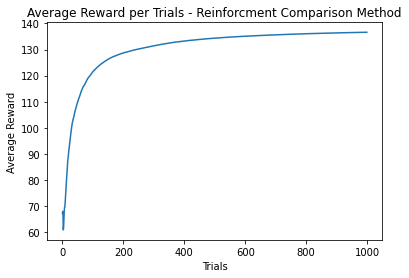

In [28]:
d,optimal_action,regret= main_run(env_3)
d = np.cumsum(d)
for i in range(len(d)):
  d[i] = d[i]/(i+1)
print("action" , optimal_action)
print("reward" , max_reward)
plt.plot(d)
plt.ylabel('Average Reward')
plt.xlabel('Trials')
plt.title('Average Reward per Trials - Reinforcment Comparison Method')

Text(0.5, 1.0, 'Regret per Trials - Reinforcment Comparison Agent')

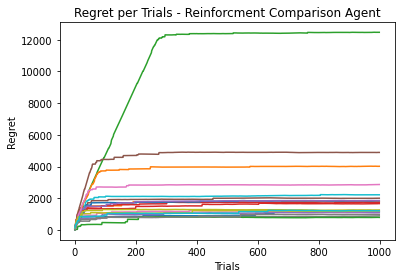

In [29]:
for i in range(len(regret)):
  plt.plot(regret[i])
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Regret per Trials - Reinforcment Comparison Agent')

Text(0.5, 1.0, 'Mean Regret for 20 epoch')

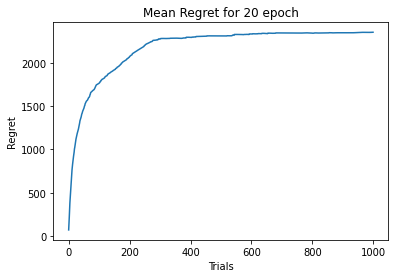

In [30]:
plt.plot(np.mean(regret,axis = 0))
plt.ylabel('Regret')
plt.xlabel('Trials')
plt.title('Mean Regret for 20 epoch')